# Livrable 1 - groupe 1

Nous sommes le groupe 1 composé de :  
- DELORME Alexandre
- ENCOGNERE Yanis
- MENNERON Laurine
- PEREON Alexandre
- ROCHARD Léo

## Contenu du livrable
TODO...


# TODO

##  Analyse des Résultats et Biais/VarianceAnalyse

Discussion sur le surapprentissage/sous-apprentissage

Calcul et affichage d'une matrice de confusion

Calcul de métriques supplémentaires (précision, rappel, F1-score)

## À implémenter/discuter:

Régularisation L2 dans les couches denses/convolutionnelles

Ajustement du taux de dropout

Utilisation de Batch Normalization

Transfer learning avec un modèle pré-entraîné (VGG16, ResNet, etc.)

Grid search pour optimiser les hyperparamètres

## Documentation et Justifications

Schéma de l'architecture du réseau (peut être généré avec tf.keras.utils.plot_model)

Justification des choix (architecture, hyperparamètres, etc.)

Analyse des résultats obtenus

Discussion sur les difficultés rencontrées (images réalistes dans les peintures)

## Gestion des Données Déséquilibrées

Analyse du déséquilibre entre classes photo/non-photo

Techniques pour gérer le déséquilibre (poids de classe, oversampling, etc.)

## EDA
TODO...
- Chargement du dataset
- Visualisation
- Répartition des données

### Chargement des bibliothèques

In [2]:
import os
import PIL
import imghdr
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import gdown
import zipfile
import pathlib

In [6]:
# ID du fichier (extrait de l'URL)
file_id = "1Q5QttYirEHvto38l6e6uk66Fjvuk_V7I"
dataset_path = "dataset_livrable_1"
zip_path = dataset_path + ".zip"
extract_dir = pathlib.Path(zip_path).parent / dataset_path

# Vérifier si le dossier existe déjà
if not os.path.exists(extract_dir):
    print(f"Le dossier '{extract_dir}' n'existe pas. Téléchargement en cours...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

    # Extraction du fichier ZIP
    print(f"Extraction ZIP en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction Zip terminée")
else:
    print(f"Le dossier '{extract_dir}' existe déjà. Téléchargement et extraction non nécessaires.")

data_dir = extract_dir
print(f"Dataset disponible dans : {data_dir}")


Le dossier 'dataset_livrable_1' existe déjà. Téléchargement et extraction non nécessaires.
Dataset disponible dans : dataset_livrable_1


In [7]:
categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Catégories détectées : {categories}")

validation_split = 0.2
seed = 42

batch_size = 32
img_height = 180
img_width = 180

Catégories détectées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


### Pré traitement des images

In [10]:
# Function to detect and remove corrupted files
num_skipped = 0
for folder_name in categories:
    folder_path = data_dir / folder_name
    for fname in os.listdir(folder_path):
        fpath = folder_path / fname
        try:
            # Check if the file is a valid image
            if imghdr.what(fpath) is None:
                raise IOError(f"File is not a valid image: {fpath}")
            
            # Try to open the image file
            with tf.io.gfile.GFile(fpath, 'rb') as f:
                img_content = f.read()
            try:
                img = tf.io.decode_image(img_content, dtype=tf.dtypes.uint8, channels=3)
            except tf.errors.InvalidArgumentError as e:
                print(f"Invalid image detected and removed: {fpath}")
                num_skipped += 1
                os.remove(fpath)
                continue
        except (IOError, SyntaxError) as e:
            print(f"Corrupted file detected and removed: {fpath}")
            num_skipped += 1
            os.remove(fpath)

print(f"Number of corrupted files removed: {num_skipped}")

Corrupted file detected and removed: dataset_livrable_1\Painting\painting_02351.jpg
Corrupted file detected and removed: dataset_livrable_1\Painting\painting_05486.jpg
Corrupted file detected and removed: dataset_livrable_1\Painting\painting_09519.jpg
Corrupted file detected and removed: dataset_livrable_1\Schematics\schematics_05998.jpg
Number of corrupted files removed: 4


### Chargement des images

In [15]:
train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

class_names = train_set.class_names
num_classes = len(class_names)

print(f"Classes found: {class_names}")

Found 0 files belonging to 5 classes.
Using 0 files for training.


ValueError: No images found in directory C:\Users\LÃ©o\Documents\Projets\Datascientist\projet-datascience-a5\dataset_livrable_1. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

### Visualisation

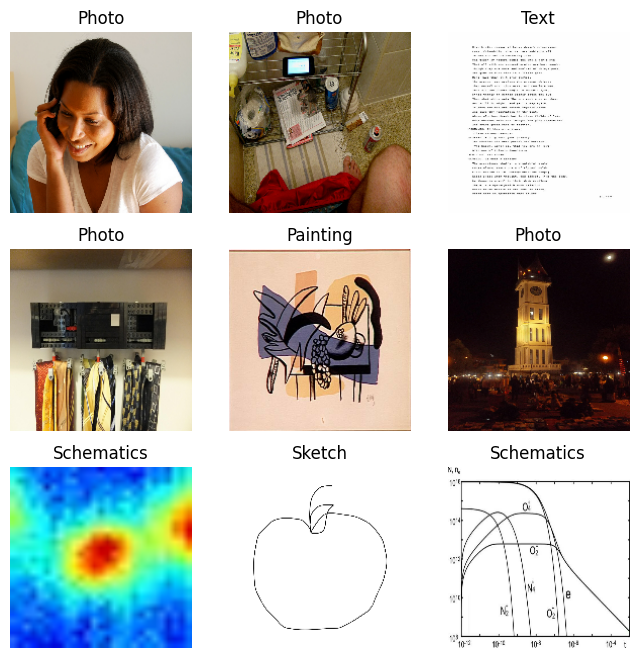

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Répartition des classes

{'Painting': 8008, 'Text': 8065, 'Photo': 7965, 'Schematics': 7363, 'Sketch': 1139}


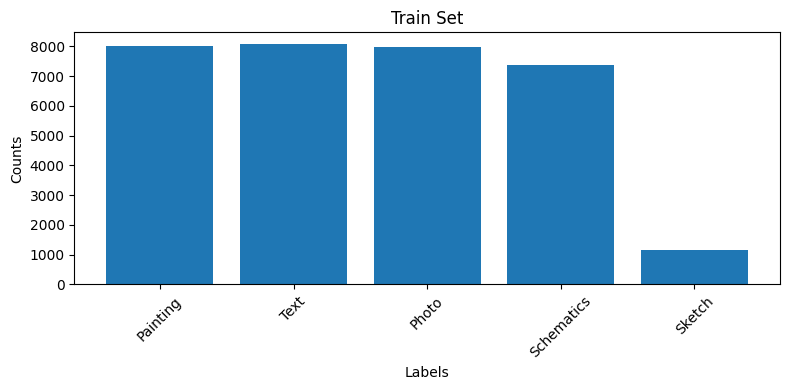

In [ ]:
def count_images_foreach_label(dataset):
    label_counts = Counter(class_names[label] for _, labels in dataset for label in labels)
    return dict(label_counts)

# Count labels in train and validation sets
train_label_counts = count_images_foreach_label(train_set)
val_label_counts = count_images_foreach_label(val_set)

# Extract data for plotting
labels, train_counts = zip(*train_label_counts.items())

# Print counts
print(train_label_counts)

# Plot Train Set Distribution
plt.figure(figsize=(8, 4))
plt.bar(labels, train_counts)
plt.xticks(rotation=45)
plt.title('Train Set')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()


## Modélisation

### Optimisation pour l'entrainement

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

### Définition du modèle

In [ ]:
# Le modèle
model = Sequential()

# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Ajout des couches au modèle
model.add(data_augmentation)
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))  # Ajout de la couche Dropout
model.add(layers.Dense(num_classes))

# Compilation du modèle
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

### Entrainement

#### Définition du early callback 

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./L1_model.keras', save_best_only=True)

#### Fit

In [ ]:
epochs=10

history = model.fit(train_set, 
          epochs=epochs,
          batch_size=batch_size,
          validation_data=val_set,
          verbose=1, 
          callbacks=[early_stopping, model_checkpoint])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()